# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [1]:
import random
random.gauss(450.,25.)

489.33156361369555

In [2]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
#         new_thrust = random.gauss(450., 25.)
#         return [new_thrust + random.gauss(0., 1.) for x in range(4)]
        return np.array([0,0,0,0])


Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [1]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

In [4]:


# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data1.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4','reward']
results = {x : [] for x in labels}

# print(task.reset())

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = [0,0,0,0]# agent.act()
        _, reward, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)+[reward]
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break
#         break

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

The next code cell visualizes the velocity of the quadcopter.

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

Finally, you can use the code cell below to print the agent's choice of actions.  

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [5]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[  0.   0.  10.   0.   0.   0.]
[ 0.  0.  0.]
[ 0.  0.  0.]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [6]:
!pwd

/notebooks/Reinforcement learning final Project/RL-Quadcopter-2


In [1]:
import os

from pathlib import Path

In [3]:
labels = ['epsiode_no','time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4','reward']
results = {x : [] for x in labels}
file_output = 'data.txt' 

In [4]:
def write_to_file(i_episode,task,action,reward):
    to_write = [i_episode]+[task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action)+[reward]
    for ii in range(len(labels)):
        results[labels[ii]].append(to_write[ii])
    writer.writerow(to_write)

Training the agent below...

In [5]:
%load_ext autoreload
%autoreload 2

import csv
import sys
import pandas as pd
from agents.agent import My_Agent
from task import Task
import tensorflow as tf
import numpy as np



In [6]:

num_episodes = 3200
target_pos = np.array([0., 0., 1.])
task = Task(target_pos=target_pos,runtime=10.)
agent = My_Agent(task) 
agent.pretrain_memory()
rewards_list = []
Best_Episode_reward = -1500
checkpoint_reward_dict = dict()

# tf.reset_default_graph()
saver = tf.train.Saver()

In [7]:



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    with open(file_output, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(labels)
    
    
        for i_episode in range(1, num_episodes+1):
            state = agent.reset_episode() # start a new episode
            while True:
                action = agent.act(state,sess) 
                next_state, reward, done = task.step(action)
                agent.step(state,action,reward,next_state, done,sess)
                state = next_state

                if i_episode%10 == 0 or i_episode == num_episodes:
                    write_to_file(i_episode,task,action,reward)

                if done:
                    if Best_Episode_reward < agent.episode_reward:
                        Best_Episode_reward = agent.episode_reward
                        
                        key_name = "checkpoints_{}".format(i_episode)
                        checkpoint_reward_dict[key_name] = agent.episode_reward
                        print(key_name, checkpoint_reward_dict[key_name])
                        Path(os.path.join(os.getcwd(),'checkpoints/checkpoints_{}'.format(i_episode))).mkdir(parents=True, exist_ok=True)
                        saver.save(sess, "checkpoints/checkpoints_{}/Quadcopter.ckpt".format(i_episode))
                    

                    rewards_list.append((i_episode, agent.episode_reward))
                    print("\rEpisode = {:4d}, episode_reward = {:7.3f},Best_Episode_reward = {:7.3f} )".format(i_episode, agent.episode_reward,Best_Episode_reward), end="")

                    
                    break
                
        saver.save(sess, "checkpoints/Quadcopter.ckpt".format(i_episode))

checkpoints_1 759.844827578
Episode =    2, episode_reward = 551.257,Best_Episode_reward = 759.845 )checkpoints_3 772.954207304
Episode =    3, episode_reward = 772.954,Best_Episode_reward = 772.954 )checkpoints_4 1021.14974439
Episode =   18, episode_reward = 919.828,Best_Episode_reward = 1021.150 ))checkpoints_19 1159.66503558
Episode =   24, episode_reward = 736.757,Best_Episode_reward = 1159.665 ))checkpoints_25 1463.84951537
Episode = 1401, episode_reward = 874.832,Best_Episode_reward = 1463.850 ))checkpoints_1402 2187.53604032
Episode = 1701, episode_reward = 1929.341,Best_Episode_reward = 2187.536 )checkpoints_1702 2615.33655513
Episode = 1704, episode_reward =   6.299,Best_Episode_reward = 2615.337 ))checkpoints_1705 13724.3157577
Episode = 1768, episode_reward =   0.538,Best_Episode_reward = 13724.316 )))checkpoints_1769 15828.5764742
Episode = 2899, episode_reward = 9665.270,Best_Episode_reward = 15828.576 ))checkpoints_2900 24065.912991
Episode = 3200, episode_reward =  93.2



## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

### Plotting Rewards Rolling Average(in Blue) with per episode rewards (in gray) 

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
    
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

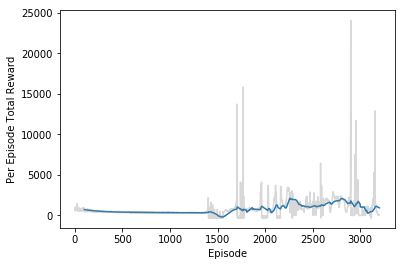

In [9]:
epsds, rwrds = np.array(rewards_list).T
smoothed_rews = running_mean(rwrds, 100)
plt.plot(epsds[-len(smoothed_rews):], smoothed_rews)
plt.plot(epsds, rwrds, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Per Episode Total Reward')

It can be clearly seen below that rewards have started to increase with rolling average of 600

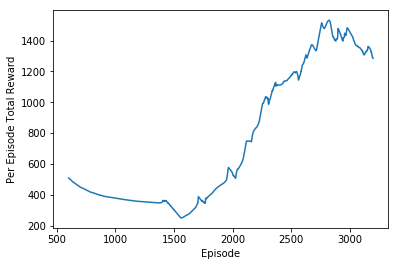

In [10]:
# Per Episode Total rewards...
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 600)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
# plt.yscale('log')
plt.xlabel('Episode')
plt.ylabel('Per Episode Total Reward')


### Training Loss Plot over all steps

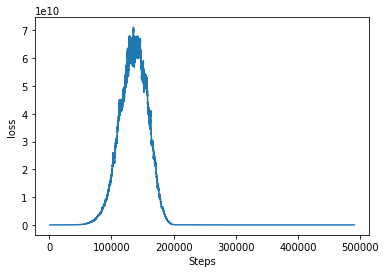

In [11]:

lst = [(idx,val) for idx, val in enumerate(agent.loss_list)]

eps1, rews1 = np.array(lst).T
smoothed_rews1 = running_mean(rews1, 1000)
plt.plot(eps1[-len(smoothed_rews1):], smoothed_rews1)
# plt.yscale('log')
# plt.plot(eps1, rews1, color='grey', alpha=0.3)
plt.xlabel('Steps')
plt.ylabel('loss')

### To make a test run from learned Network

In [7]:
i_episode = 1

In [8]:

def write_to_test_file(i_episode,task,action,reward):
    to_write = [i_episode]+[task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action)+[reward]
    for ii in range(len(labels)):
        test_results[labels[ii]].append(to_write[ii])
    writer.writerow(to_write)

In [9]:
test_results = {x : [] for x in labels}

In [10]:
with tf.Session() as sess:
    
    saver.restore(sess,tf.train.latest_checkpoint(os.path.join(os.getcwd(),'checkpoints/checkpoints_1705')))
    file_output = 'testrun.txt'
    rewards_list_test_run = []
    task = Task(target_pos=target_pos,runtime=18.)
    
                  
    with open(file_output, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(labels)
        
        state = agent.reset_episode() # start a new episode
        t_reward = 0
        while True:
            action = agent.act(state,sess,is_training=False) 
            next_state, reward, done = task.step(action)
            t_reward += reward
            state = next_state

            write_to_test_file(1,task,action,reward)

            if done:

                rewards_list_test_run.append((i_episode, t_reward))
                print("\rEpisode = {:4d}, episode_reward = {:7.3f} )".format(i_episode, t_reward), end="")
                break

INFO:tensorflow:Restoring parameters from /notebooks/Reinforcement learning final Project/RL-Quadcopter-2/checkpoints/checkpoints_1705/Quadcopter.ckpt
Episode =    1, episode_reward = 31381.602 )

***Below are the plots of the last runs(training last run and Test run), not to confuse two lines are coming because one shows training last run and the other shows Test run.***

**Note**: In the below plot (x,y,z) have started to stabilize after a mega push upward, may be we can see it coming down to landing 
position if we run the simulation for little longer. we can expect it to come down seeing the Z velocity in the next plot below.

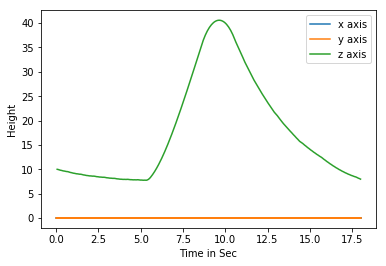

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.clf()

plt.plot(test_results['time'], test_results['x'], label='x axis')
plt.plot(test_results['time'], test_results['y'], label='y axis')
plt.plot(test_results['time'][:-1], test_results['z'][:-1], label='z axis')
plt.xlabel('Time in Sec')
plt.ylabel('Height')
plt.legend()
_ = plt.ylim()

In the below plot, Z velocity has come down to -ve to bring down the quadcopter

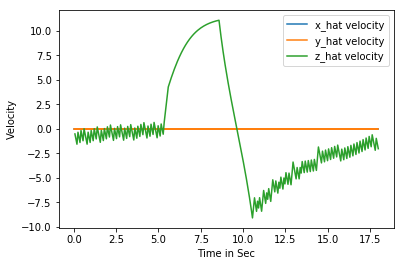

In [20]:
plt.plot(test_results['time'], test_results['x_velocity'], label='x_hat velocity')
plt.plot(test_results['time'], test_results['y_velocity'], label='y_hat velocity')
plt.plot(test_results['time'][:-1], test_results['z_velocity'][:-1], label='z_hat velocity')
plt.xlabel('Time in Sec')
plt.ylabel('Velocity')
plt.legend()
_ = plt.ylim()

In the plot below the level of rotor speeds have been brought down after the initial push upwards toward the begining.

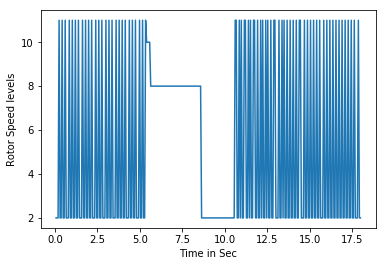

In [21]:
plt.plot(test_results['time'][:-1], test_results['rotor_speed4'][:-1], label='Rotor speed levels')
plt.xlabel('Time in Sec')
plt.ylabel('Rotor Speed levels')
# plt.legend()
_ = plt.ylim()

**Note** : since the push was only in the +ve Z direction which lead to no change in phi,psi, theta and their corresponding
    velocities

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

In task.py the reward function is split into two parts; first its target is to reach a desired height, then second target is to come down close to landing position [0,0,1].

The rewards increases exponentially from starting potions [0,0,10] to a desired height z=20, and once the desired height is reached, then its rewards increases exponentially as it approaches closer to landing position.

If it goes beyond the upper/lower bounds of the environments it is penalized with -100 reward.


The action space is also descritized into 15 different levels 10 to 900 spaced equally, having same speed for all the 4 rotors at each level for e.g (100,100,100,100), so that it becomes easy for the quadcopter to go up or come down.

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:


I tried Deep Q learning algorithm, with this we can see it is starting to act with desired behaviour for our task.

The final choice of hyperparamerters are listed below:

        self.explore_stop = 0.01
        self.explore_start = 1.0
        self.decay_rate = 0.00001  # this decay rate causing exploration to happen for all 3200 episodes
        self.gamma = 0.99
        
         # Network parameters
        hidden_size = 64               # number of units in each Q-network hidden layer
        learning_rate = 0.00001         # Q-network learning rate
        
        memory_size = 10000            # memory capacity
        self.batch_size = 60           # experience mini-batch size
        
The architecture of Neural Network is as listed below:

Input size 30, output size 15 nodes with linear output.
Three hidden layers each has 64 nodes with Elu activation.

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

The rewards plot the rolling average over 100 episodes to see the improvement in the agent learning the task.

It is not an easy task to learn as the agent is struggling to learn to come down quicky to landing point.

As the agent is exploring at the begining causing it to hit the simulation boundries and get penalized heavily, which it learns to avoid later. However, the agent still struggles to come down to the landing point after reaching a desired height, although it does make efforts to come down by reducing the +ve Z velocity and increasing the -ve Z velocity at the end of an episode.

The rewards collected at the end are coming around 10000 which I think may increase if we train it for further more episodes so it learns to come down quickly and collect more rewards, but I see there are oscillations in the training loss which may be fixed with Fixed Target approach, but could not try it.


However, several other settings tried include reducing the size of hidden layers to 32 and number of hidden layers to 2, also tried batch normalization but it was performing poorly with that, not sure why. Also, the reward function has been changed from linear rewards to exponential rewards as it moves toward its target position.


**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:

After spending almost three weeks just on the final Project, I am literally exhausted and desperately need a break.
I think the hardest part is designing the Task, as that pretty much dominates other things. The task comprise of two tasks one to reach a desired height and then make it land safely to a desired point. Besides that this Project needs perfect balance of everything to master the desired task.

However, I learnt that if there is slightest difference in the 4 rotor speeds, the quadcopter comes crashing down to surface, also increasing the number of rotor speed levels from 9 to 15 does help to acheive the desired task.
Secondly, if the Task is not clear or too complex than the agent learns to find ways to increase rewards even we cannot imagine.
Thirdly, it is highly recommended in my experience to give enough time to the agent to explore which is the key but equally important is to stop exploring at right point and start exploiting the learned actions-rewards.